In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
import time


In [12]:
BASE_DIR = "/Users/Deep Learning Core"
IMG_DIR = os.path.join(BASE_DIR, "img_align_celeba")
IDENTITY_FILE = os.path.join(BASE_DIR, "identity_CelebA.txt")

BATCH_SIZE = 32
NUM_EPOCHS = 10  # Start with 10 epochs
LEARNING_RATE = 0.001
IMAGE_SIZE = 128
NUM_CELEBRITIES = 20

In [13]:
class CelebADataset(Dataset):
    def __init__(self, image_names, labels, img_dir, transform=None):
        self.image_names = image_names
        self.labels = labels
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_names[idx])
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        # After 3 pooling: 128->64->32->16
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

Loading data...
Added celebrity 10173 to the list

Using 20 celebrities
Total images: 638
Celebrity 10173: 30 images (label=19)

Data split:
Train: 408
Val: 102
Test: 128

Device: cpu

Epoch 1/10


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.46it/s]


Train Acc: 5.64%, Val Acc: 10.78%

Epoch 2/10


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.20it/s]


Train Acc: 10.29%, Val Acc: 26.47%

Epoch 3/10


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.72it/s]


Train Acc: 23.53%, Val Acc: 22.55%

Epoch 4/10


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.00it/s]


Train Acc: 28.92%, Val Acc: 24.51%

Epoch 5/10


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.84it/s]


Train Acc: 36.52%, Val Acc: 36.27%

Epoch 6/10


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.74it/s]


Train Acc: 45.10%, Val Acc: 40.20%

Epoch 7/10


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.96it/s]


Train Acc: 52.45%, Val Acc: 41.18%

Epoch 8/10


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.11it/s]


Train Acc: 59.80%, Val Acc: 37.25%

Epoch 9/10


Validation: 100%|██████████| 4/4 [00:00<00:00, 12.18it/s]


Train Acc: 71.32%, Val Acc: 47.06%

Epoch 10/10


Validation: 100%|██████████| 4/4 [00:00<00:00, 11.81it/s]


Train Acc: 74.26%, Val Acc: 43.14%


Testing: 100%|██████████| 4/4 [00:00<00:00,  8.31it/s]


Test Accuracy: 42.97%

Celebrity 10173 Accuracy: 33.33% (2/6)


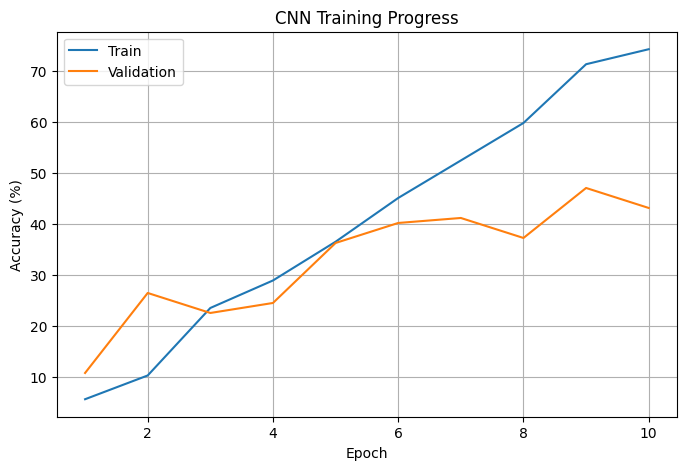


Model saved as 'cnn_model.pth'
Plot saved as 'cnn_results.png'


In [15]:
def main():
    
    print("Loading data...")
    identity_df1 = pd.read_csv(IDENTITY_FILE, sep=' ', header=None, names=['image', 'identity'])
    
    # Get top N celebrities
    celebrity_counts = identity_df1['identity'].value_counts()
    top_celebrities = celebrity_counts.head(NUM_CELEBRITIES).index.tolist()
    
    # Check if 10173 is included
    if 10173 in celebrity_counts.index and 10173 not in top_celebrities:
        top_celebrities[-1] = 10173
        print("Added celebrity 10173 to the list")
    
    # Filter data
    mask = identity_df1['identity'].isin(top_celebrities)
    filtered_df = identity_df1[mask].copy()
    
    # Create label mapping
    celebrity_to_label = {celeb: idx for idx, celeb in enumerate(sorted(top_celebrities))}
    label_to_celebrity = {idx: celeb for celeb, idx in celebrity_to_label.items()}
    
    filtered_df['label'] = filtered_df['identity'].map(celebrity_to_label)
    
    print(f"\nUsing {NUM_CELEBRITIES} celebrities")
    print(f"Total images: {len(filtered_df)}")
    
    # Check celebrity 10173
    if 10173 in celebrity_to_label:
        count_10173 = (filtered_df['identity'] == 10173).sum()
        print(f"Celebrity 10173: {count_10173} images (label={celebrity_to_label[10173]})")
    
    # Get data
    image_names = filtered_df['image'].tolist()
    labels = filtered_df['label'].tolist()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        image_names, labels, test_size=0.2, random_state=42, stratify=labels
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    print(f"\nData split:")
    print(f"Train: {len(X_train)}")
    print(f"Val: {len(X_val)}")
    print(f"Test: {len(X_test)}")
    
    # Transforms
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Datasets
    train_dataset = CelebADataset(X_train, y_train, IMG_DIR, transform)
    val_dataset = CelebADataset(X_val, y_val, IMG_DIR, transform)
    test_dataset = CelebADataset(X_test, y_test, IMG_DIR, transform)
    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    # Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nDevice: {device}")
    
    model = SimpleCNN(NUM_CELEBRITIES)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Training
    
    
    train_accs = []
    val_accs = []
    
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        
        # Training
        model.train()
        train_correct = 0
        train_total = 0
        train_loss = 0.0
        
        for images, labels_batch in tqdm(train_loader, desc="Training"):
            images = images.to(device)
            labels_batch = labels_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels_batch.size(0)
            train_correct += (predicted == labels_batch).sum().item()
        
        train_acc = 100 * train_correct / train_total
        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for images, labels_batch in tqdm(val_loader, desc="Validation"):
                images = images.to(device)
                labels_batch = labels_batch.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels_batch)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels_batch.size(0)
                val_correct += (predicted == labels_batch).sum().item()
        
        val_acc = 100 * val_correct / val_total
        
        print(f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
        
        train_accs.append(train_acc)
        val_accs.append(val_acc)
    
    
    
    model.eval()
    test_correct = 0
    test_total = 0
    test_preds = []
    test_labels = []
    
    with torch.no_grad():
        for images, labels_batch in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            labels_batch = labels_batch.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            test_total += labels_batch.size(0)
            test_correct += (predicted == labels_batch).sum().item()
            
            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels_batch.cpu().numpy())
    
    test_acc = 100 * test_correct / test_total
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    # Check celebrity 10173 performance
    if 10173 in celebrity_to_label:
        label_10173 = celebrity_to_label[10173]
        mask = np.array(test_labels) == label_10173
        if mask.sum() > 0:
            correct_10173 = (np.array(test_preds)[mask] == label_10173).sum()
            total_10173 = mask.sum()
            acc_10173 = 100 * correct_10173 / total_10173
            print(f"\nCelebrity 10173 Accuracy: {acc_10173:.2f}% ({correct_10173}/{total_10173})")
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, NUM_EPOCHS+1), train_accs, label='Train')
    plt.plot(range(1, NUM_EPOCHS+1), val_accs, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('CNN Training Progress')
    plt.legend()
    plt.grid(True)
    plt.savefig('cnn_results.png')
    plt.show()
    
    # Save model
    torch.save(model.state_dict(), 'cnn_model.pth')
    print("\nModel saved as 'cnn_model.pth'")
    print("Plot saved as 'cnn_results.png'")
    
    
if __name__ == "__main__":
    main()

Part 2 : All the Other Models

In [16]:
BASE_DIR = "/Users/Deep Learning Core"
IMG_DIR = os.path.join(BASE_DIR, "img_align_celeba")
IDENTITY_FILE = os.path.join(BASE_DIR, "identity_CelebA.txt")

BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
IMAGE_SIZE = 224  # Standard size for pre-trained models
NUM_CELEBRITIES = 20

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [18]:
class TransferLearningModel(nn.Module):
    def __init__(self, model_name, num_classes, freeze_backbone=True):
        super(TransferLearningModel, self).__init__()
        
        self.model_name = model_name
        
        # Load pre-trained model
        if model_name == 'resnet50':
            self.model = models.resnet50(pretrained=True)
            num_features = self.model.fc.in_features
            self.model.fc = nn.Linear(num_features, num_classes)
            
        elif model_name == 'resnet18':
            self.model = models.resnet18(pretrained=True)
            num_features = self.model.fc.in_features
            self.model.fc = nn.Linear(num_features, num_classes)
            
        elif model_name == 'mobilenet_v2':
            self.model = models.mobilenet_v2(pretrained=True)
            num_features = self.model.classifier[1].in_features
            self.model.classifier = nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(num_features, num_classes)
            )
            
        elif model_name == 'efficientnet_b0':
            self.model = models.efficientnet_b0(pretrained=True)
            num_features = self.model.classifier[1].in_features
            self.model.classifier = nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(num_features, num_classes)
            )
            
        elif model_name == 'vgg16':
            self.model = models.vgg16(pretrained=True)
            num_features = self.model.classifier[6].in_features
            self.model.classifier[6] = nn.Linear(num_features, num_classes)
            
        else:
            raise ValueError(f"Model {model_name} not supported")
        
        # Freeze backbone if specified
        if freeze_backbone:
            self._freeze_backbone()
    
    def _freeze_backbone(self):
        """Freeze all layers except the final classifier"""
        if self.model_name in ['resnet50', 'resnet18']:
            for param in self.model.parameters():
                param.requires_grad = False
            for param in self.model.fc.parameters():
                param.requires_grad = True
                
        elif self.model_name in ['mobilenet_v2', 'efficientnet_b0']:
            for param in self.model.parameters():
                param.requires_grad = False
            for param in self.model.classifier.parameters():
                param.requires_grad = True
                
        elif self.model_name == 'vgg16':
            for param in self.model.features.parameters():
                param.requires_grad = False
            for param in self.model.classifier.parameters():
                param.requires_grad = True
    
    def forward(self, x):
        return self.model(x)


In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name):
    """Train a model and return training history"""
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} - {model_name}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in tqdm(train_loader, desc="Training"):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_{model_name}_model.pth')
            print(f"Saved best model with validation accuracy: {best_val_acc:.2f}%")
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }


In [20]:
def evaluate_model(model, test_loader, celebrity_to_label, model_name):
    """Evaluate model on test set"""
    
    model.eval()
    test_correct = 0
    test_total = 0
    test_preds = []
    test_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Testing {model_name}"):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    
    test_acc = 100 * test_correct / test_total
    
    # Check celebrity 10173 performance
    celeb_10173_acc = None
    if 10173 in celebrity_to_label:
        label_10173 = celebrity_to_label[10173]
        mask = np.array(test_labels) == label_10173
        if mask.sum() > 0:
            correct_10173 = (np.array(test_preds)[mask] == label_10173).sum()
            total_10173 = mask.sum()
            celeb_10173_acc = 100 * correct_10173 / total_10173
    
    return test_acc, celeb_10173_acc

Loading data...
Added celebrity 10173 to the list

Using 20 celebrities
Total images: 638
Celebrity 10173: 30 images (label=19)

Data split:
Train: 408
Val: 102
Test: 128

Training resnet18 (Freeze backbone: True)


/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/regata3010/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 39.1MB/s]



Epoch 1/10 - resnet18


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Train Loss: 3.0740, Train Acc: 8.09%
Val Loss: 2.7502, Val Acc: 15.69%
Saved best model with validation accuracy: 15.69%

Epoch 2/10 - resnet18


Validation: 100%|██████████| 4/4 [00:00<00:00, 18.57it/s]


Train Loss: 2.5641, Train Acc: 24.02%
Val Loss: 2.4301, Val Acc: 29.41%
Saved best model with validation accuracy: 29.41%

Epoch 3/10 - resnet18


Validation: 100%|██████████| 4/4 [00:00<00:00, 18.34it/s]


Train Loss: 2.1783, Train Acc: 46.08%
Val Loss: 2.1865, Val Acc: 50.98%
Saved best model with validation accuracy: 50.98%

Epoch 4/10 - resnet18


Validation: 100%|██████████| 4/4 [00:00<00:00, 18.56it/s]


Train Loss: 1.9329, Train Acc: 56.37%
Val Loss: 1.9724, Val Acc: 51.96%
Saved best model with validation accuracy: 51.96%

Epoch 5/10 - resnet18


Validation: 100%|██████████| 4/4 [00:00<00:00, 17.09it/s]


Train Loss: 1.6627, Train Acc: 70.34%
Val Loss: 1.8299, Val Acc: 59.80%
Saved best model with validation accuracy: 59.80%

Epoch 6/10 - resnet18


Validation: 100%|██████████| 4/4 [00:00<00:00, 18.52it/s]


Train Loss: 1.4384, Train Acc: 78.92%
Val Loss: 1.7081, Val Acc: 64.71%
Saved best model with validation accuracy: 64.71%

Epoch 7/10 - resnet18


Validation: 100%|██████████| 4/4 [00:00<00:00, 18.14it/s]


Train Loss: 1.3268, Train Acc: 81.13%
Val Loss: 1.5721, Val Acc: 65.69%
Saved best model with validation accuracy: 65.69%

Epoch 8/10 - resnet18


Validation: 100%|██████████| 4/4 [00:00<00:00, 18.71it/s]


Train Loss: 1.1603, Train Acc: 82.60%
Val Loss: 1.5296, Val Acc: 67.65%
Saved best model with validation accuracy: 67.65%

Epoch 9/10 - resnet18


Validation: 100%|██████████| 4/4 [00:00<00:00, 18.32it/s]


Train Loss: 1.0400, Train Acc: 87.01%
Val Loss: 1.4261, Val Acc: 70.59%
Saved best model with validation accuracy: 70.59%

Epoch 10/10 - resnet18


Validation: 100%|██████████| 4/4 [00:00<00:00, 18.70it/s]


Train Loss: 0.9523, Train Acc: 88.48%
Val Loss: 1.3745, Val Acc: 67.65%


Testing resnet18: 100%|██████████| 4/4 [00:00<00:00, 13.03it/s]
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Results for resnet18:
Best Validation Accuracy: 70.59%
Test Accuracy: 62.50%
Celebrity 10173 Accuracy: 50.00%
Training Time: 16.78 seconds

Training resnet50 (Freeze backbone: True)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/regata3010/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 50.0MB/s]



Epoch 1/10 - resnet50


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Train Loss: 3.0102, Train Acc: 11.76%
Val Loss: 2.6267, Val Acc: 13.73%
Saved best model with validation accuracy: 13.73%

Epoch 2/10 - resnet50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]


Train Loss: 2.4017, Train Acc: 32.60%
Val Loss: 2.2841, Val Acc: 39.22%
Saved best model with validation accuracy: 39.22%

Epoch 3/10 - resnet50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.72it/s]


Train Loss: 1.9401, Train Acc: 51.23%
Val Loss: 2.0054, Val Acc: 46.08%
Saved best model with validation accuracy: 46.08%

Epoch 4/10 - resnet50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.70it/s]


Train Loss: 1.6117, Train Acc: 66.67%
Val Loss: 1.7918, Val Acc: 50.98%
Saved best model with validation accuracy: 50.98%

Epoch 5/10 - resnet50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.55it/s]


Train Loss: 1.3266, Train Acc: 76.47%
Val Loss: 1.7022, Val Acc: 53.92%
Saved best model with validation accuracy: 53.92%

Epoch 6/10 - resnet50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]


Train Loss: 1.1599, Train Acc: 78.68%
Val Loss: 1.5610, Val Acc: 56.86%
Saved best model with validation accuracy: 56.86%

Epoch 7/10 - resnet50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.80it/s]


Train Loss: 1.0603, Train Acc: 81.13%
Val Loss: 1.5512, Val Acc: 60.78%
Saved best model with validation accuracy: 60.78%

Epoch 8/10 - resnet50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.68it/s]


Train Loss: 0.9346, Train Acc: 83.58%
Val Loss: 1.4127, Val Acc: 63.73%
Saved best model with validation accuracy: 63.73%

Epoch 9/10 - resnet50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.74it/s]


Train Loss: 0.8085, Train Acc: 90.69%
Val Loss: 1.3493, Val Acc: 63.73%

Epoch 10/10 - resnet50


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.65it/s]


Train Loss: 0.7164, Train Acc: 91.18%
Val Loss: 1.3414, Val Acc: 62.75%


Testing resnet50: 100%|██████████| 4/4 [00:00<00:00,  5.24it/s]
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/regata3010/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



Results for resnet50:
Best Validation Accuracy: 63.73%
Test Accuracy: 61.72%
Celebrity 10173 Accuracy: 83.33%
Training Time: 30.49 seconds

Training mobilenet_v2 (Freeze backbone: True)


100%|██████████| 13.6M/13.6M [00:00<00:00, 34.1MB/s]



Epoch 1/10 - mobilenet_v2


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s]


Train Loss: 2.9712, Train Acc: 7.11%
Val Loss: 2.6800, Val Acc: 20.59%
Saved best model with validation accuracy: 20.59%

Epoch 2/10 - mobilenet_v2


Validation: 100%|██████████| 4/4 [00:00<00:00, 17.76it/s]


Train Loss: 2.3164, Train Acc: 38.48%
Val Loss: 2.1934, Val Acc: 47.06%
Saved best model with validation accuracy: 47.06%

Epoch 3/10 - mobilenet_v2


Validation: 100%|██████████| 4/4 [00:00<00:00, 18.29it/s]


Train Loss: 1.8580, Train Acc: 60.78%
Val Loss: 1.8921, Val Acc: 50.98%
Saved best model with validation accuracy: 50.98%

Epoch 4/10 - mobilenet_v2


Validation: 100%|██████████| 4/4 [00:00<00:00, 16.62it/s]


Train Loss: 1.5408, Train Acc: 70.10%
Val Loss: 1.6897, Val Acc: 61.76%
Saved best model with validation accuracy: 61.76%

Epoch 5/10 - mobilenet_v2


Validation: 100%|██████████| 4/4 [00:00<00:00, 15.64it/s]


Train Loss: 1.2988, Train Acc: 79.17%
Val Loss: 1.5375, Val Acc: 66.67%
Saved best model with validation accuracy: 66.67%

Epoch 6/10 - mobilenet_v2


Validation: 100%|██████████| 4/4 [00:00<00:00, 18.61it/s]


Train Loss: 1.1167, Train Acc: 82.84%
Val Loss: 1.4321, Val Acc: 63.73%

Epoch 7/10 - mobilenet_v2


Validation: 100%|██████████| 4/4 [00:00<00:00, 18.37it/s]


Train Loss: 0.9714, Train Acc: 86.52%
Val Loss: 1.3747, Val Acc: 65.69%

Epoch 8/10 - mobilenet_v2


Validation: 100%|██████████| 4/4 [00:00<00:00, 17.12it/s]


Train Loss: 0.9116, Train Acc: 86.03%
Val Loss: 1.2884, Val Acc: 65.69%

Epoch 9/10 - mobilenet_v2


Validation: 100%|██████████| 4/4 [00:00<00:00, 18.15it/s]


Train Loss: 0.8169, Train Acc: 87.01%
Val Loss: 1.2579, Val Acc: 68.63%
Saved best model with validation accuracy: 68.63%

Epoch 10/10 - mobilenet_v2


Validation: 100%|██████████| 4/4 [00:00<00:00, 18.28it/s]


Train Loss: 0.7010, Train Acc: 89.95%
Val Loss: 1.2174, Val Acc: 63.73%


Testing mobilenet_v2: 100%|██████████| 4/4 [00:00<00:00, 12.86it/s]
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/regata3010/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



Results for mobilenet_v2:
Best Validation Accuracy: 68.63%
Test Accuracy: 65.62%
Celebrity 10173 Accuracy: 50.00%
Training Time: 14.41 seconds

Training efficientnet_b0 (Freeze backbone: True)


100%|██████████| 20.5M/20.5M [00:00<00:00, 37.3MB/s]



Epoch 1/10 - efficientnet_b0


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


Train Loss: 2.9084, Train Acc: 11.27%
Val Loss: 2.6749, Val Acc: 38.24%
Saved best model with validation accuracy: 38.24%

Epoch 2/10 - efficientnet_b0


Validation: 100%|██████████| 4/4 [00:00<00:00, 15.57it/s]


Train Loss: 2.3920, Train Acc: 53.68%
Val Loss: 2.3334, Val Acc: 49.02%
Saved best model with validation accuracy: 49.02%

Epoch 3/10 - efficientnet_b0


Validation: 100%|██████████| 4/4 [00:00<00:00, 15.59it/s]


Train Loss: 1.9857, Train Acc: 75.25%
Val Loss: 2.0820, Val Acc: 52.94%
Saved best model with validation accuracy: 52.94%

Epoch 4/10 - efficientnet_b0


Validation: 100%|██████████| 4/4 [00:00<00:00, 15.47it/s]


Train Loss: 1.6971, Train Acc: 84.56%
Val Loss: 1.8884, Val Acc: 60.78%
Saved best model with validation accuracy: 60.78%

Epoch 5/10 - efficientnet_b0


Validation: 100%|██████████| 4/4 [00:00<00:00, 15.76it/s]


Train Loss: 1.4218, Train Acc: 88.24%
Val Loss: 1.7357, Val Acc: 63.73%
Saved best model with validation accuracy: 63.73%

Epoch 6/10 - efficientnet_b0


Validation: 100%|██████████| 4/4 [00:00<00:00, 15.42it/s]


Train Loss: 1.2411, Train Acc: 90.93%
Val Loss: 1.6264, Val Acc: 61.76%

Epoch 7/10 - efficientnet_b0


Validation: 100%|██████████| 4/4 [00:00<00:00, 15.71it/s]


Train Loss: 1.0831, Train Acc: 91.42%
Val Loss: 1.5534, Val Acc: 65.69%
Saved best model with validation accuracy: 65.69%

Epoch 8/10 - efficientnet_b0


Validation: 100%|██████████| 4/4 [00:00<00:00, 15.56it/s]


Train Loss: 0.9366, Train Acc: 95.59%
Val Loss: 1.4683, Val Acc: 66.67%
Saved best model with validation accuracy: 66.67%

Epoch 9/10 - efficientnet_b0


Validation: 100%|██████████| 4/4 [00:00<00:00, 15.62it/s]


Train Loss: 0.8392, Train Acc: 96.32%
Val Loss: 1.4041, Val Acc: 63.73%

Epoch 10/10 - efficientnet_b0


Validation: 100%|██████████| 4/4 [00:00<00:00, 15.78it/s]


Train Loss: 0.7599, Train Acc: 95.34%
Val Loss: 1.3898, Val Acc: 64.71%


Testing efficientnet_b0: 100%|██████████| 4/4 [00:00<00:00, 11.41it/s]



Results for efficientnet_b0:
Best Validation Accuracy: 66.67%
Test Accuracy: 71.09%
Celebrity 10173 Accuracy: 33.33%
Training Time: 17.18 seconds


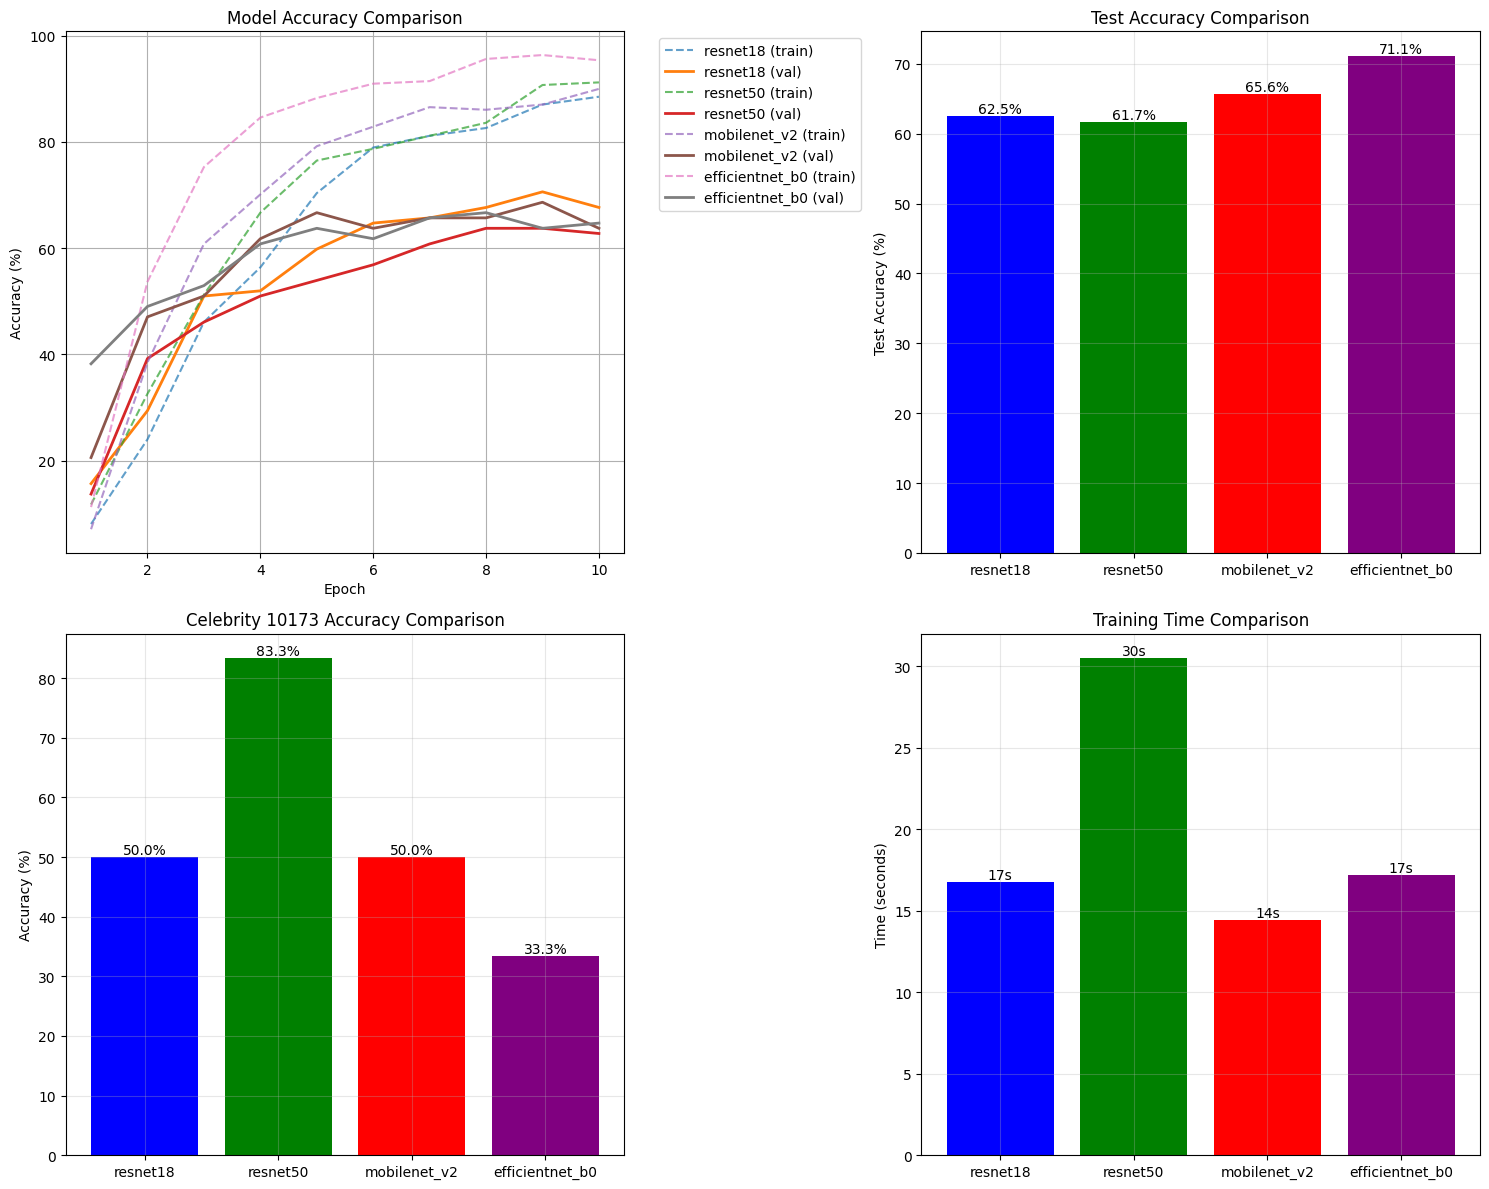


FINAL RESULTS SUMMARY
Model                Val Acc      Test Acc     10173 Acc    Time (s)  
--------------------------------------------------------------------------------
resnet18             70.59%       62.50%       50.00%       16.8
resnet50             63.73%       61.72%       83.33%       30.5
mobilenet_v2         68.63%       65.62%       50.00%       14.4
efficientnet_b0      66.67%       71.09%       33.33%       17.2

All models saved with prefix 'best_[model_name]_model.pth'
Comparison plot saved as 'transfer_learning_comparison.png'


In [21]:
def main():
    
    print("Loading data...")
    identity_df = pd.read_csv(IDENTITY_FILE, sep=' ', header=None, names=['image', 'identity'])
    
    # Get top N celebrities
    celebrity_counts = identity_df['identity'].value_counts()
    top_celebrities = celebrity_counts.head(NUM_CELEBRITIES).index.tolist()
    
    # Ensure celebrity 10173 is included
    if 10173 in celebrity_counts.index and 10173 not in top_celebrities:
        top_celebrities[-1] = 10173
        print("Added celebrity 10173 to the list")
    
    # Filter and label data
    mask = identity_df['identity'].isin(top_celebrities)
    filtered_df = identity_df[mask].copy()
    
    celebrity_to_label = {celeb: idx for idx, celeb in enumerate(sorted(top_celebrities))}
    filtered_df['label'] = filtered_df['identity'].map(celebrity_to_label)
    
    print(f"\nUsing {NUM_CELEBRITIES} celebrities")
    print(f"Total images: {len(filtered_df)}")
    
    if 10173 in celebrity_to_label:
        count_10173 = (filtered_df['identity'] == 10173).sum()
        print(f"Celebrity 10173: {count_10173} images (label={celebrity_to_label[10173]})")
    
    # Split data
    image_names = filtered_df['image'].tolist()
    labels = filtered_df['label'].tolist()
    
    X_train, X_test, y_train, y_test = train_test_split(
        image_names, labels, test_size=0.2, random_state=42, stratify=labels
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    print(f"\nData split:")
    print(f"Train: {len(X_train)}")
    print(f"Val: {len(X_val)}")
    print(f"Test: {len(X_test)}")
    
    # Data transforms for pre-trained models
    transform_train = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    transform_val = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = CelebADataset(X_train, y_train, IMG_DIR, transform_train)
    val_dataset = CelebADataset(X_val, y_val, IMG_DIR, transform_val)
    test_dataset = CelebADataset(X_test, y_test, IMG_DIR, transform_val)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    # Models to train
    model_configs = [
        {'name': 'resnet18', 'freeze': True},
        {'name': 'resnet50', 'freeze': True},
        {'name': 'mobilenet_v2', 'freeze': True},
        {'name': 'efficientnet_b0', 'freeze': True},
    ]
    
    results = {}
    
    # Train each model
    for config in model_configs:
        model_name = config['name']
        freeze_backbone = config['freeze']
        
        print(f"\n{'='*60}")
        print(f"Training {model_name} (Freeze backbone: {freeze_backbone})")
        print('='*60)
        
        # Create model
        model = TransferLearningModel(model_name, NUM_CELEBRITIES, freeze_backbone)
        model = model.to(device)
        
        # Setup training
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                               lr=LEARNING_RATE)
        
        # Train model
        start_time = time.time()
        history = train_model(model, train_loader, val_loader, criterion, 
                            optimizer, NUM_EPOCHS, model_name)
        training_time = time.time() - start_time
        
        # Evaluate on test set
        test_acc, celeb_10173_acc = evaluate_model(model, test_loader, 
                                                   celebrity_to_label, model_name)
        
        # Store results
        results[model_name] = {
            'history': history,
            'test_acc': test_acc,
            'celeb_10173_acc': celeb_10173_acc,
            'training_time': training_time,
            'best_val_acc': history['best_val_acc']
        }
        
        print(f"\nResults for {model_name}:")
        print(f"Best Validation Accuracy: {history['best_val_acc']:.2f}%")
        print(f"Test Accuracy: {test_acc:.2f}%")
        if celeb_10173_acc is not None:
            print(f"Celebrity 10173 Accuracy: {celeb_10173_acc:.2f}%")
        print(f"Training Time: {training_time:.2f} seconds")
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Training Accuracy Comparison
    ax1 = axes[0, 0]
    for model_name in results:
        ax1.plot(range(1, NUM_EPOCHS+1), 
                results[model_name]['history']['train_accs'], 
                label=f'{model_name} (train)', linestyle='--', alpha=0.7)
        ax1.plot(range(1, NUM_EPOCHS+1), 
                results[model_name]['history']['val_accs'], 
                label=f'{model_name} (val)', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Model Accuracy Comparison')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True)
    
    # Plot 2: Test Accuracy Bar Chart
    ax2 = axes[0, 1]
    model_names = list(results.keys())
    test_accs = [results[m]['test_acc'] for m in model_names]
    bars = ax2.bar(model_names, test_accs, color=['blue', 'green', 'red', 'purple'][:len(model_names)])
    ax2.set_ylabel('Test Accuracy (%)')
    ax2.set_title('Test Accuracy Comparison')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    
    # Plot 3: Celebrity 10173 Accuracy
    if any(results[m]['celeb_10173_acc'] is not None for m in model_names):
        ax3 = axes[1, 0]
        celeb_accs = [results[m]['celeb_10173_acc'] if results[m]['celeb_10173_acc'] is not None else 0 
                     for m in model_names]
        bars = ax3.bar(model_names, celeb_accs, color=['blue', 'green', 'red', 'purple'][:len(model_names)])
        ax3.set_ylabel('Accuracy (%)')
        ax3.set_title('Celebrity 10173 Accuracy Comparison')
        ax3.grid(True, alpha=0.3)
        
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax3.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}%', ha='center', va='bottom')
    
    # Plot 4: Training Time Comparison
    ax4 = axes[1, 1]
    training_times = [results[m]['training_time'] for m in model_names]
    bars = ax4.bar(model_names, training_times, color=['blue', 'green', 'red', 'purple'][:len(model_names)])
    ax4.set_ylabel('Time (seconds)')
    ax4.set_title('Training Time Comparison')
    ax4.grid(True, alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}s', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('transfer_learning_comparison.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    # Print summary table
    print("\n" + "="*80)
    print("FINAL RESULTS SUMMARY")
    print("="*80)
    print(f"{'Model':<20} {'Val Acc':<12} {'Test Acc':<12} {'10173 Acc':<12} {'Time (s)':<10}")
    print("-"*80)
    
    for model_name in results:
        r = results[model_name]
        celeb_str = f"{r['celeb_10173_acc']:.2f}%" if r['celeb_10173_acc'] is not None else "N/A"
        print(f"{model_name:<20} {r['best_val_acc']:.2f}%{'':<6} "
              f"{r['test_acc']:.2f}%{'':<6} {celeb_str:<12} {r['training_time']:.1f}")
    
    print("="*80)
    print("\nAll models saved with prefix 'best_[model_name]_model.pth'")
    print("Comparison plot saved as 'transfer_learning_comparison.png'")

if __name__ == "__main__":
    main()